### Pipeline

In [1]:
import pandas as pd
import string
import re
import json
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from underthesea import word_tokenize
from transformers import pipeline

d:\Documents\Ki_8\NLP\Comment-Sentiment-Analysis\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
corrector = pipeline("text2text-generation", model="./vietnamese-correction-v2")

Device set to use cpu


In [3]:
class VietnamesePreprocessing:
    def __init__(self):
        # Load Vietnamese stopwords
        with open('../data/vietnamese.txt', 'r', encoding='utf-8') as file:
            self.stop_words = set(word.strip() for word in file.read().splitlines())
        with open('../data/vi-abbreviations.json', 'r', encoding='utf-8') as file:
            self.abbreviations = json.load(file)

    def clean(self, x: str) -> str:
        """Clean the text by removing unwanted characters or patterns."""
        x = re.sub(r'\s+', ' ', x)
        x = re.sub(r'[^\w\s]', '', x)
        x = re.sub(r'\b0', '', x) # remove digit 0 at the beginning
        # remove phone number vietnam like 0954223654, 0856452325, 0123456789
        x = re.sub(r'(\d{10})', '', x)
        # remove phone number vietnam like xxx223654
        x = re.sub(r"\b\d{1,4}([*._-]{1,5}\d{1,5})+\b", '', x)
        # remove number stand alone
        x = re.sub(r'\b\d+\b', '', x)
        x = re.sub(r'\b(?:\d{3}|\d{2})[xX]*\d{6,10}\b', '', x)
        x = re.sub(r'\b(?:\d{4}|\d{3})[xX]*\d{6,10}\b', '', x)
        x = x.strip()  # Remove leading/trailing spaces
        return x

    def to_lower(self, x: str) -> str:
        """Convert all text to lowercase."""
        return x.lower()

    def delete_punctuation(self, x: str) -> str:
        """Remove punctuation from the text."""
        return x.translate(str.maketrans('', '', string.punctuation))

    def tokenize_text(self, x: str) -> list:
        """Tokenize the text into words."""
        return word_tokenize(x)

    def delete_stop_words(self, x: str) -> str:
        """Remove stopwords from the text."""
        return ' '.join([word for word in x.split() if word not in self.stop_words])
    
    def replace_abbreviations(self, x: str) -> str:
        """Replace abbreviations in the text using the loaded dictionary."""
        return ' '.join([self.abbreviations.get(word, word) for word in x.split()])
    
    def correct_spelling(self, x: str) -> str:
        """Correct spelling using the loaded model."""
        return corrector(x)[0]['generated_text']
    
    def __call__(self, x: str):
        """Apply the preprocessing pipeline to the input text."""
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.delete_punctuation(x)
        x = self.replace_abbreviations(x)  # Apply abbreviation replacement
        x = self.delete_stop_words(x)  # Remove stopwords
        # x = self.correct_spelling(x)
        return x

# Initialize the VietnamesePreprocessing class with the abbreviation dictionary
preprocessor = VietnamesePreprocessing()

# Read your CSV file
df = pd.read_csv('../data/phone_ratings_cleaned_1.csv')

# Delete row which have empty comment
df = df[df['comment'] != '']

# Remove row with comment have less than 1 character
df = df[df['comment'].notna()]  # Ensure there are no NaN values
df = df[df['comment'].astype(str).apply(lambda x: len(x) > 1)] 

# Apply preprocessing to the 'comment' column (or whichever column you want to process)
# Pass the index along with the data
for idx, row in df.iterrows():
    print(f"Processing row {idx + 1}")  # Print the current row index (1-based)
    df.at[idx, 'comment'] = preprocessor(row['comment'])  # Apply preprocessing

# Join all processed comments into a single text
all_comments = ' '.join(df['comment'])


Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Processing row 8
Processing row 9
Processing row 10
Processing row 11
Processing row 12
Processing row 13
Processing row 14
Processing row 15
Processing row 16
Processing row 17
Processing row 18
Processing row 19
Processing row 20
Processing row 21
Processing row 22
Processing row 23
Processing row 24
Processing row 25
Processing row 26
Processing row 27
Processing row 28
Processing row 29
Processing row 30
Processing row 31
Processing row 32
Processing row 33
Processing row 34
Processing row 35
Processing row 36
Processing row 37
Processing row 38
Processing row 39
Processing row 40
Processing row 41
Processing row 42
Processing row 43
Processing row 44
Processing row 45
Processing row 46
Processing row 47
Processing row 48
Processing row 49
Processing row 50
Processing row 51
Processing row 52
Processing row 53
Processing row 54
Processing row 55
Processing row 56
P

### Phân tích số lượng từ

In [4]:
df.head()

,product_id,comment,rating,source_file,word_count,tokenized_comment
0,honor-x8b,đừng mua linh kiện,1,ratings\honor-x8b.csv,6,Đừng mua không có linh_kiện .
1,honor-x8b,máy ghét zalo vui báo hiện gọi,3,ratings\honor-x8b.csv,15,"Máy sao cũng được ghét nhất cái zalo , vui nó ..."
2,honor-x8b,điện thoại mỏng chip máy mượt,5,ratings\honor-x8b.csv,16,Chiếc điện_thoại mỏng nhất tôi từng dùng cũng ...
3,honor-x8b,hôm mua tặng tai giới thiệu hôm đấy,4,ratings\honor-x8b.csv,17,Sao hôm tôi mua lại không được tặng tai nghe n...
4,honor-x8b,mua tuần trả bao nhiêu,3,ratings\honor-x8b.csv,10,Em mua được tuần trả lại mất bao_nhiêu ạ ?


In [5]:
df.shape

(2312, 6)

In [6]:
df["word_count"] = df["comment"].astype(str).apply(lambda x: len(x.split()))

In [7]:
df[["comment", "word_count"]].sort_values(by="word_count", ascending=False).head()

,comment,word_count
301,điện thoại tắt chế độ máy bay tắt wifi gạt hết...,14
116,nhân viên thân thiện tư vấn nhiệt tình cảm ơn ...,14
429,dịch vụ giới di động bây kém mua điện thoại bá...,14
2287,mua trực tiếp giới di động trần văn thời cà ma...,14
1362,may sai muot ma pin cam rat ok gia tien nhan v...,14


### Biểu đồ tần suất

In [8]:
df['tokenized_comment'] = df['comment'].apply(lambda x: word_tokenize(x, format="text"))

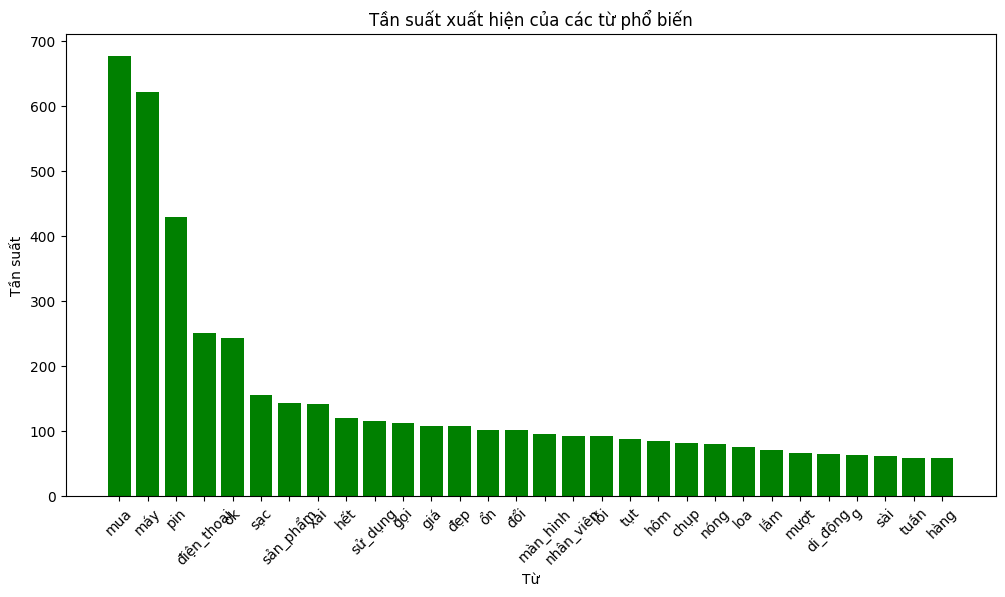

In [9]:
# Tạo biểu đồ tần suất từ
all_words = " ".join(df["tokenized_comment"].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)  # Lấy 20 từ phổ biến nhất
 
words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='green')
plt.xticks(rotation=45)
plt.xlabel("Từ")
plt.ylabel("Tần suất")
plt.title("Tần suất xuất hiện của các từ phổ biến")
plt.show()

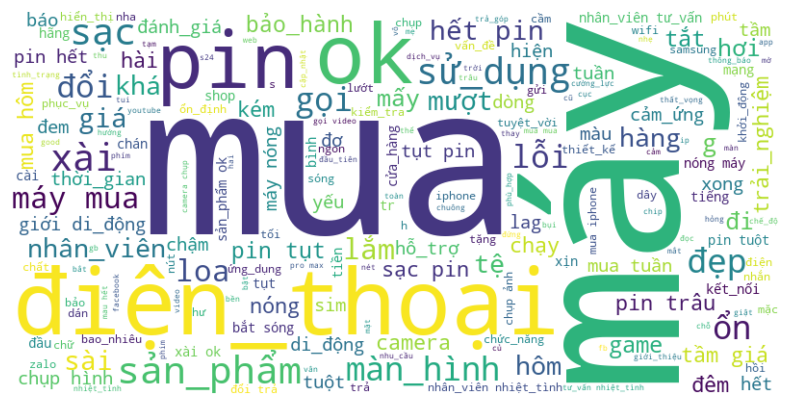

In [10]:
all_comments = ' '.join(df['tokenized_comment'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for word cloud
plt.show()

In [14]:
# Tìm các phần tử chứachứa từ 'pin' bên trong các bình luận ở mảng all_comments
pin_comments = [comment for comment in all_comments.split() if 'pin' in comment]
pin_comments

['pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'mượt_pin',
 'pin',
 'pin',
 'tụt_pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'hài_pin',
 'pin',
 'đẹp_pin',
 'pin_tác',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'hài_pin',
 'pin',
 'đẹp_pin',
 'pin_tác',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'tuột_pin',
 'pin',
 'hao_pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'mượt_pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'thời_pin',
 'mượt_pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'mượt_pin',
 'pin',
 'mượt_pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'trở_pin',
 'pin',
 'pin',
 'pin',
 'pin',
 'pin',
 

In [11]:
df.to_csv('../data/phone_ratings_cleaned.csv', index=False)